<a href="https://colab.research.google.com/github/pserpaschiavo/svc-degradation-detection/blob/main/python/notebooks/SFI2_TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/pserpaschiavo/svc-degradation-detection/refs/heads/main/python/datasets/unloaded-concorrencia-long.csv", low_memory=False)

df.head()

,time,sent,received,latency_min,latency_median,latency_75th,latency_95th,latency_99th
0,3.000,5003,5002,112,463,2074,7775,18691.0
1,4.000,4999,5001,122,308,1567,13582,29517.0
2,5.000,5005,5005,109,305,1121,6012,9508.0
3,6.000,5001,4996,119,633,1800,10002,18919.0
4,7.000,5005,5008,122,543,1352,8810,13233.0


In [3]:
df.shape

(86398, 8)

In [4]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df.shape

(57600, 8)

In [5]:
df.latency_median = pd.to_numeric(df.latency_median, errors='coerce').fillna(0).astype(int)
df.received = pd.to_numeric(df.received, errors='coerce').fillna(0).astype(int)
df.sent = pd.to_numeric(df.sent, errors='coerce').fillna(0).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            57600 non-null  object 
 1   sent            57600 non-null  int64  
 2   received        57600 non-null  int64  
 3   latency_min     57600 non-null  object 
 4   latency_median  57600 non-null  int64  
 5   latency_75th    57597 non-null  object 
 6   latency_95th    57597 non-null  object 
 7   latency_99th    57595 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 3.5+ MB


In [6]:
print(df.latency_median.isna().sum())

print(np.isinf(df.latency_median).sum())

0
0


In [7]:
df.columns

Index(['time', 'sent', 'received', 'latency_min', 'latency_median',
       'latency_75th', 'latency_95th', 'latency_99th'],
      dtype='object')

In [8]:
df = df.drop(columns=['time', 'latency_min','latency_75th', 'latency_95th', 'latency_99th'])

df.head()

,sent,received,latency_median
0,5003,5002,463
1,4999,5001,308
2,5005,5005,305
3,5001,4996,633
4,5005,5008,543


In [9]:
df.columns = ['sent', 'received', 'latency']

df.head()

,sent,received,latency
0,5003,5002,463
1,4999,5001,308
2,5005,5005,305
3,5001,4996,633
4,5005,5008,543


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sent      57600 non-null  int64
 1   received  57600 non-null  int64
 2   latency   57600 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [11]:
df.index

RangeIndex(start=0, stop=57600, step=1)

In [12]:
latencia = df.latency

latencia.head()

,latency
0,463
1,308
2,305
3,633
4,543


In [13]:
type(df)

pandas.core.frame.DataFrame

In [14]:
time = latencia.index

In [45]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(21, 7))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

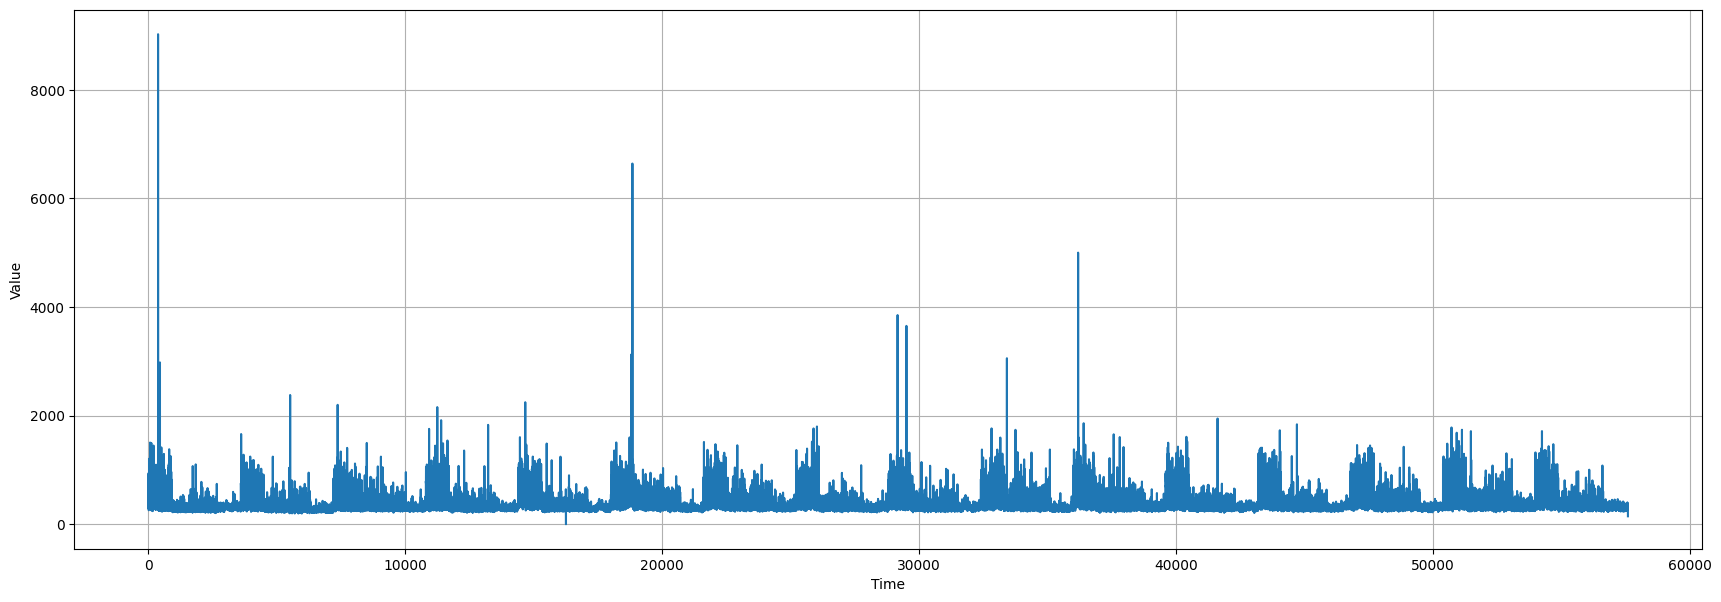

In [46]:
plot_series(time, latencia)

In [47]:
# Define the split time
# split_time = int(df.shape[0]*0.8)
split_time = 43200      # 3 training hours


# Get the train set
time_train = time[:split_time]
x_train = latencia[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = latencia[split_time:]

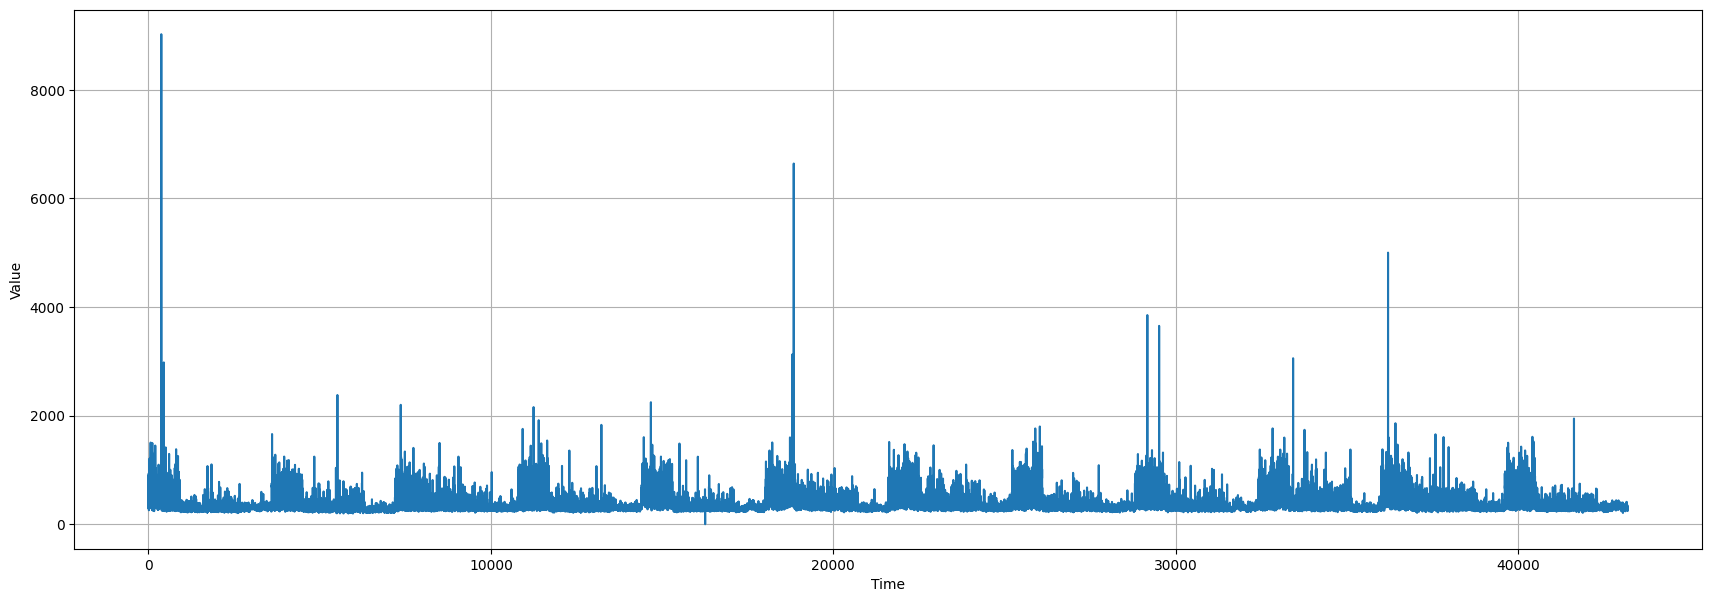

In [48]:
plot_series(time_train, x_train)

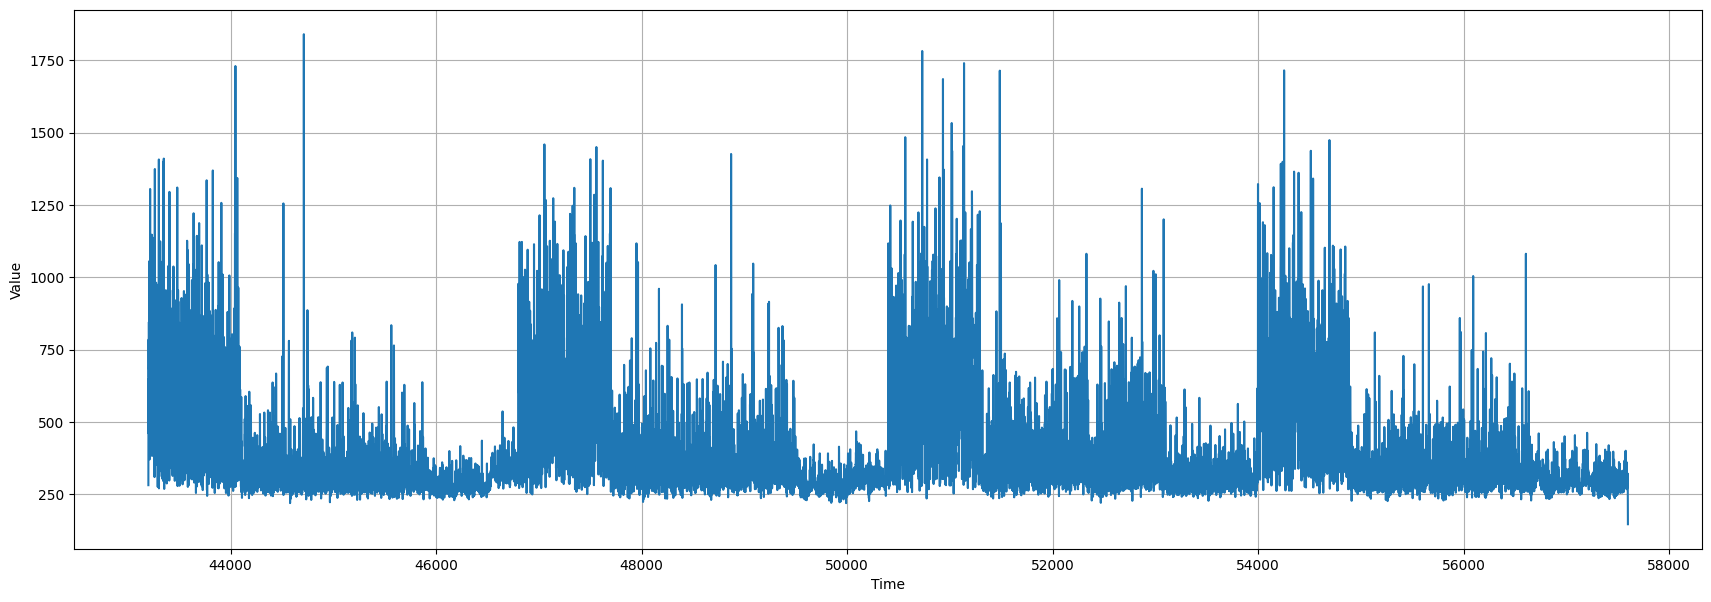

In [49]:
plot_series(time_valid, x_valid)

In [50]:
# Generate the naive forecast
naive_forecast = latencia[split_time - 1:-1]

# Define time step
time_step = 46000

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 46000: 267
prediction at time step 46001: 287


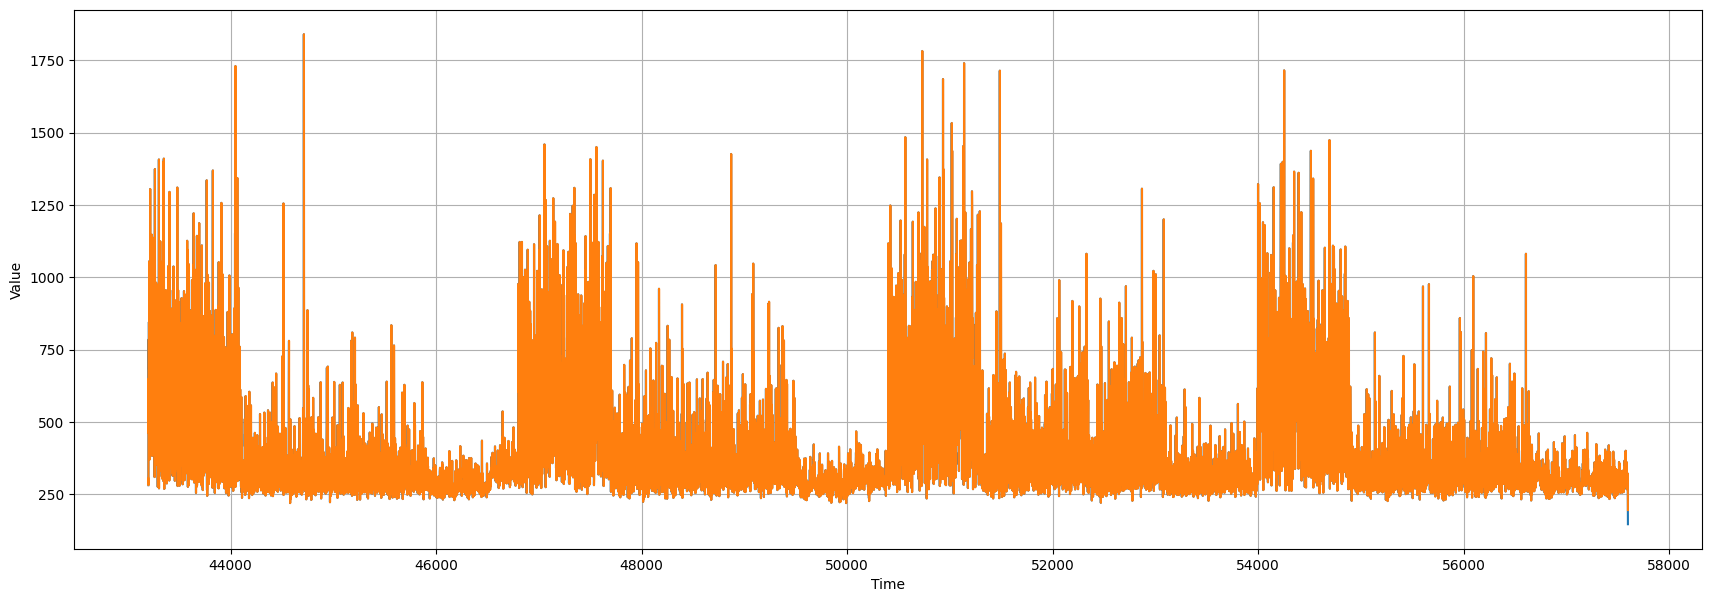

In [51]:
plot_series(time_valid, (x_valid, naive_forecast))

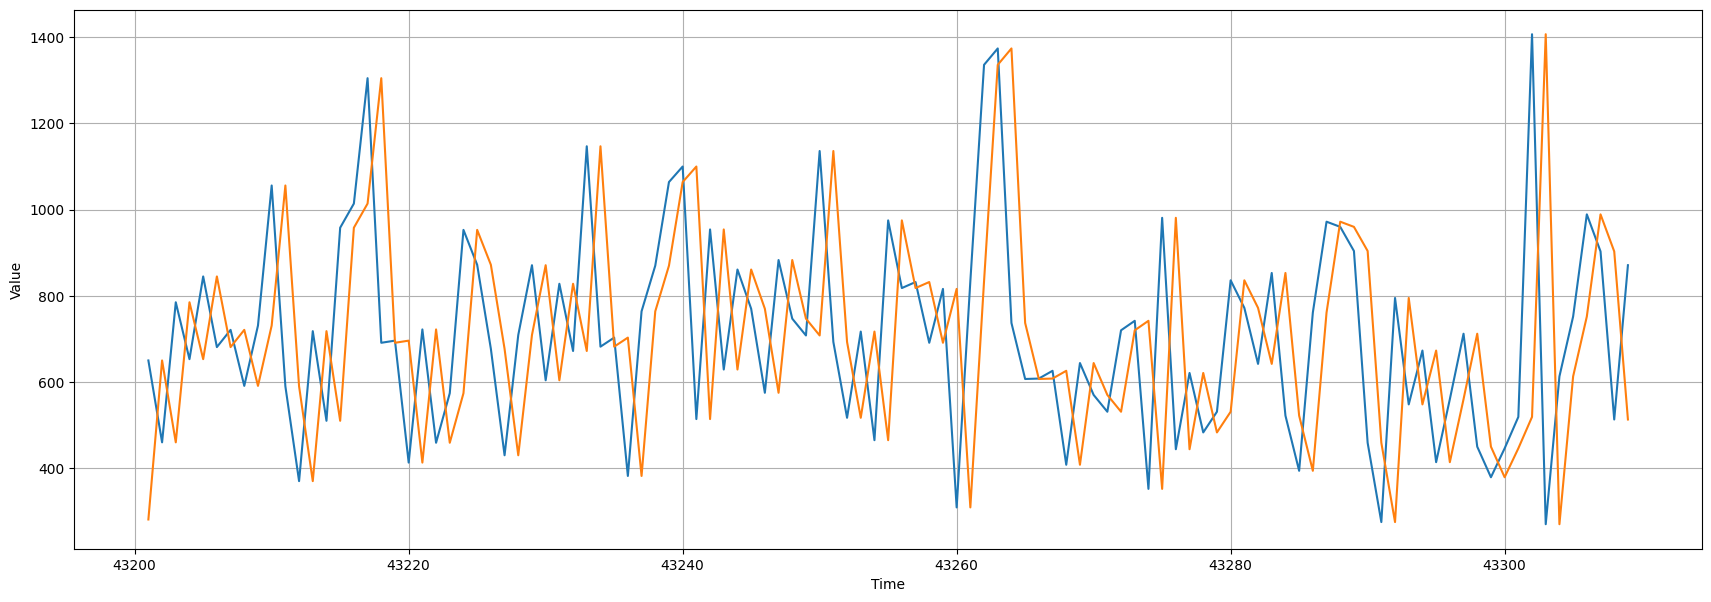

In [52]:
plot_series(time_valid, (x_valid, naive_forecast), start=1, end=110)

In [53]:
print(tf.keras.metrics.mse(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mae(x_valid, naive_forecast).numpy())

31293.855
106.79972


In [108]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

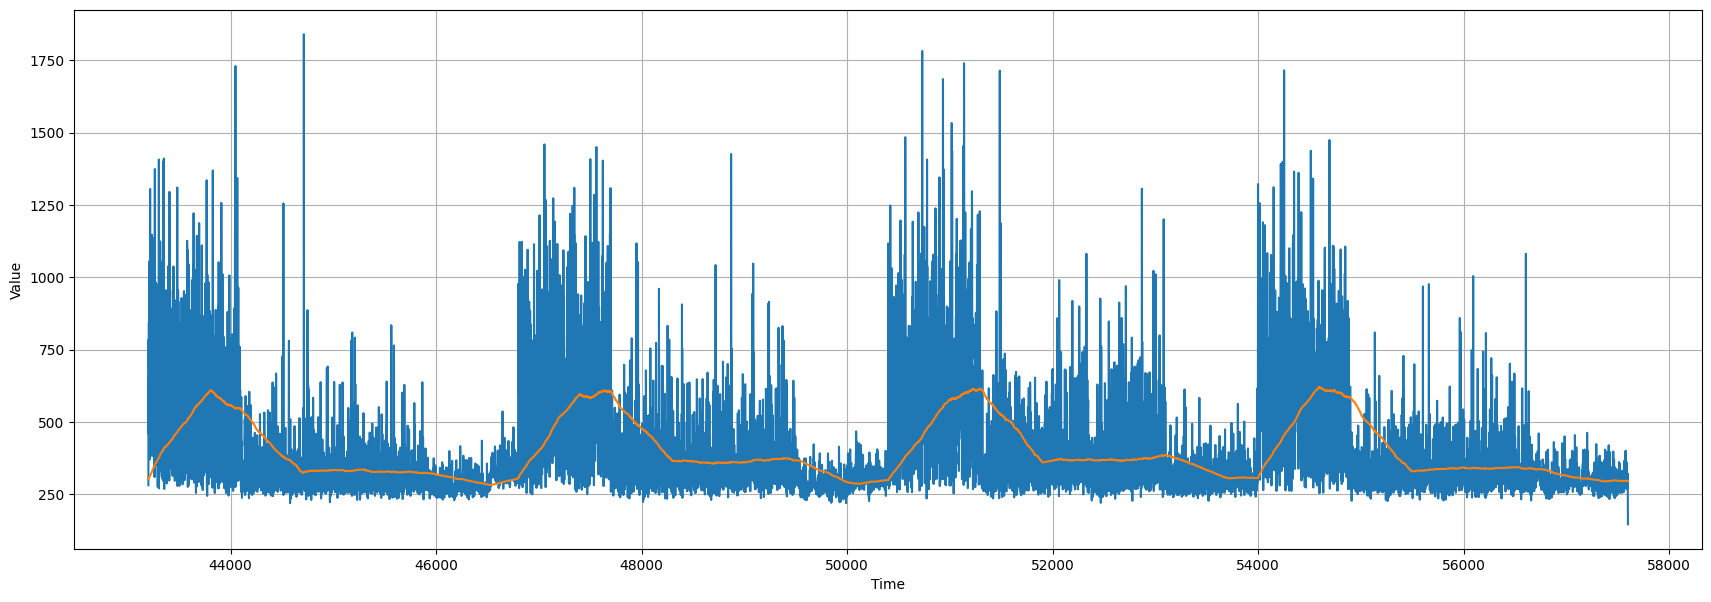

In [109]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(latencia, 600)[split_time - 600:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [110]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mae(x_valid, moving_avg).numpy())

26350.849932284913
105.38414710648148


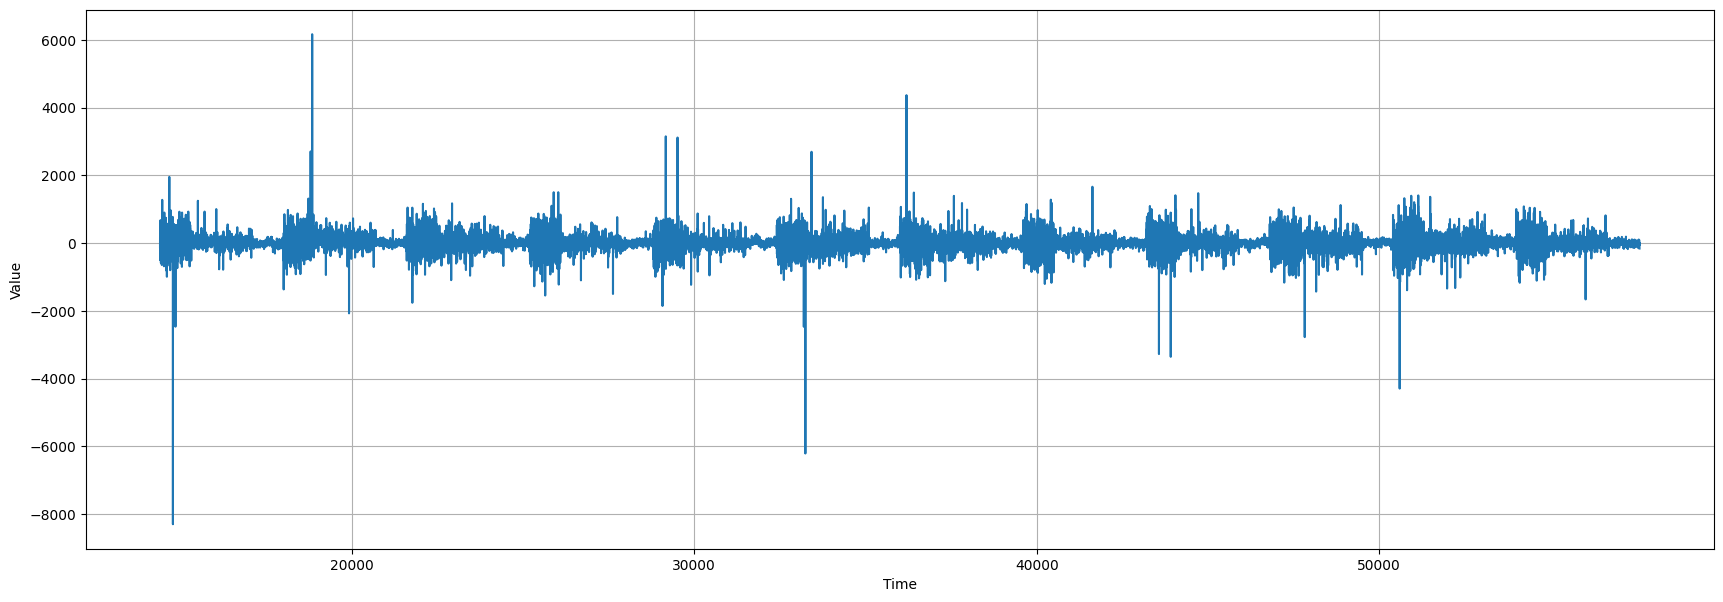

In [111]:
# Subtract the values at t-365 from original series
diff_series = ((latencia[14400:].reset_index(drop=True) - latencia[:-14400]).reset_index(drop=True))
# Truncate the first 365 time steps
diff_time = time[14400:]

# Plot the results
plot_series(diff_time, diff_series)

Tamanho de diff_moving_avg antes do corte: 42600
Tamanho de diff_series após o corte: 14400
Tamanho de diff_moving_avg após o corte: 14400


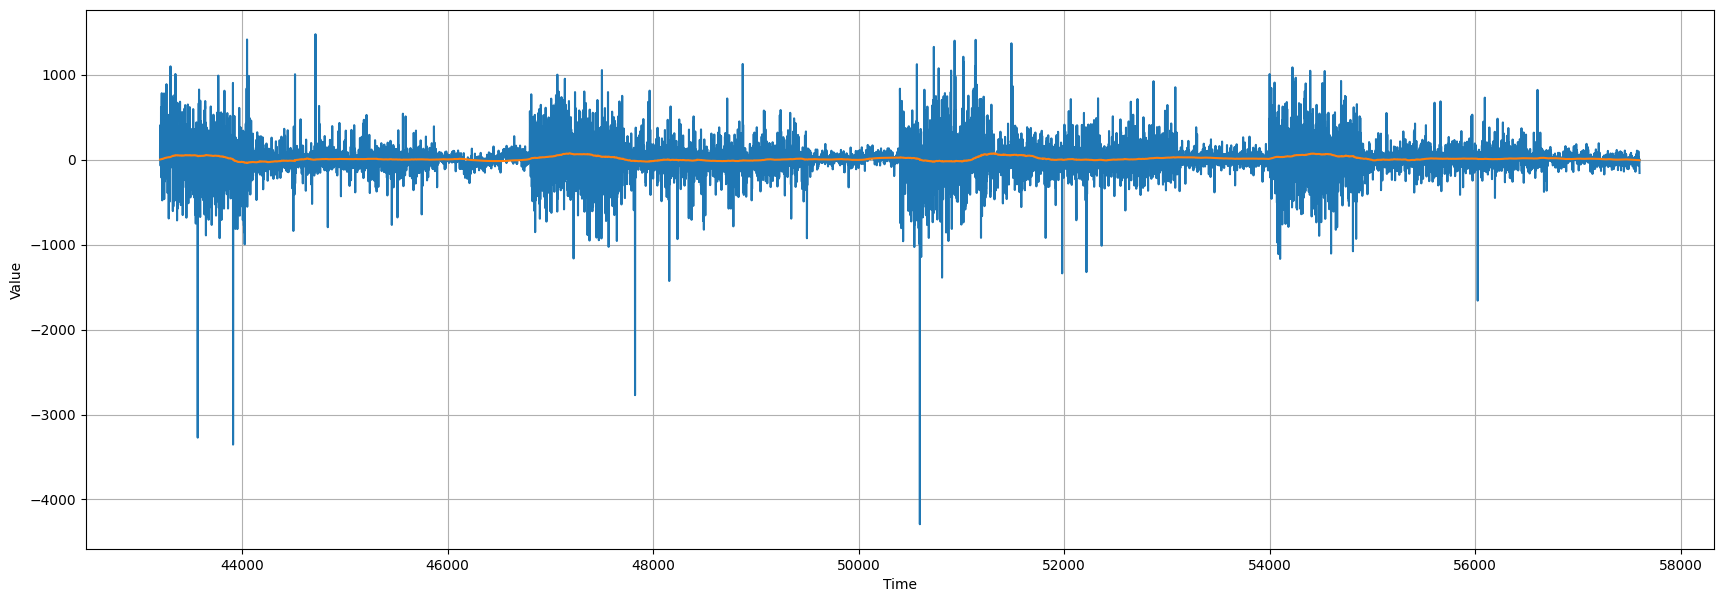

In [112]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 600)

# Verifique o tamanho de diff_moving_avg antes do corte
print(f"Tamanho de diff_moving_avg antes do corte: {len(diff_moving_avg)}")

# Slice the prediction points that corresponds to the validation set time steps
# Verifique o tamanho de split_time e 14400 para garantir que o corte está correto
diff_moving_avg = diff_moving_avg[split_time - 14400 - 600:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 14400:]

# Verifique os tamanhos das séries antes de plotar
print(f"Tamanho de diff_series após o corte: {len(diff_series)}")
print(f"Tamanho de diff_moving_avg após o corte: {len(diff_moving_avg)}")

# Plot the results, garantindo que os tamanhos sejam iguais
if len(diff_series) == len(diff_moving_avg):
    plot_series(time_valid, (diff_series, diff_moving_avg))
else:
    print("Erro: Tamanhos desalinhados entre as séries.")


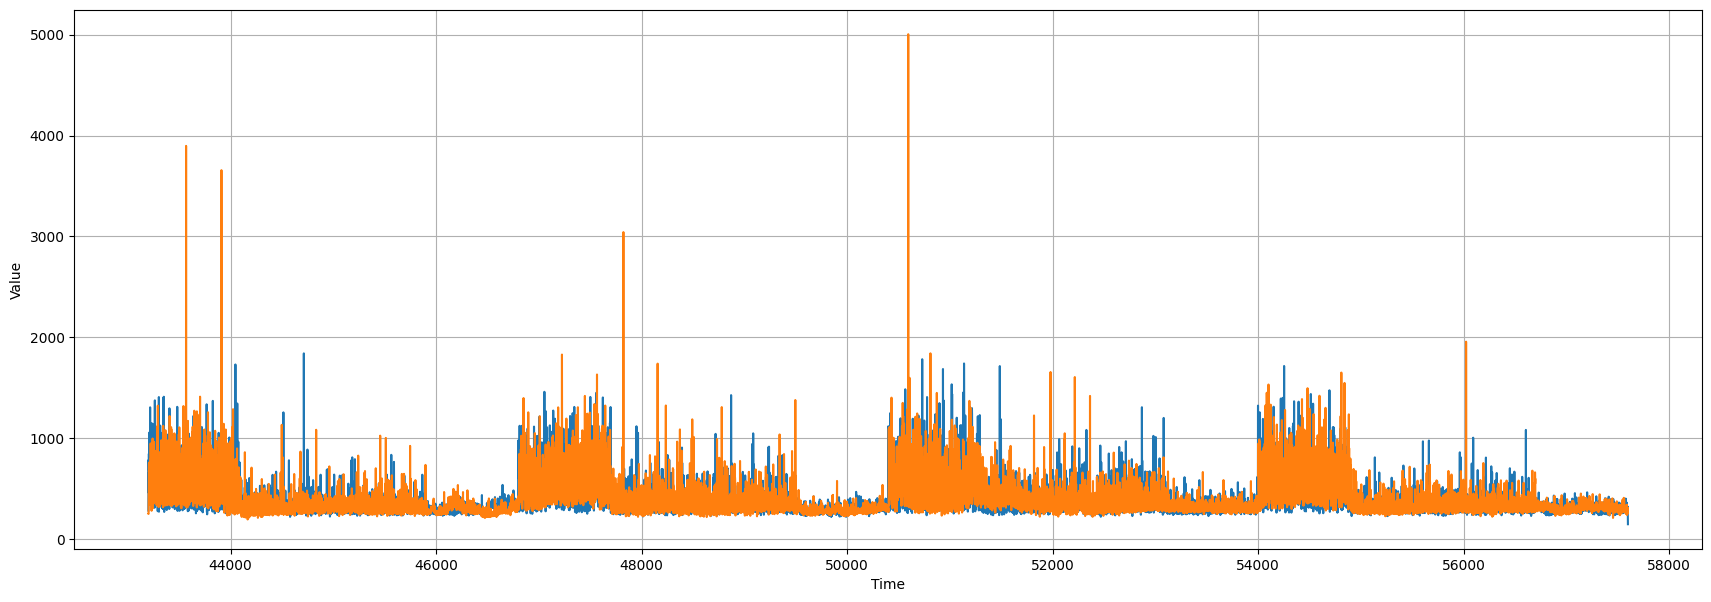

In [113]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = latencia[split_time - 14400:-14400] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [114]:
print(tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_past).numpy())

40897.44886199132
119.616465625


Tamanho de smooth_past: 14400
Tamanho de diff_moving_avg: 14400


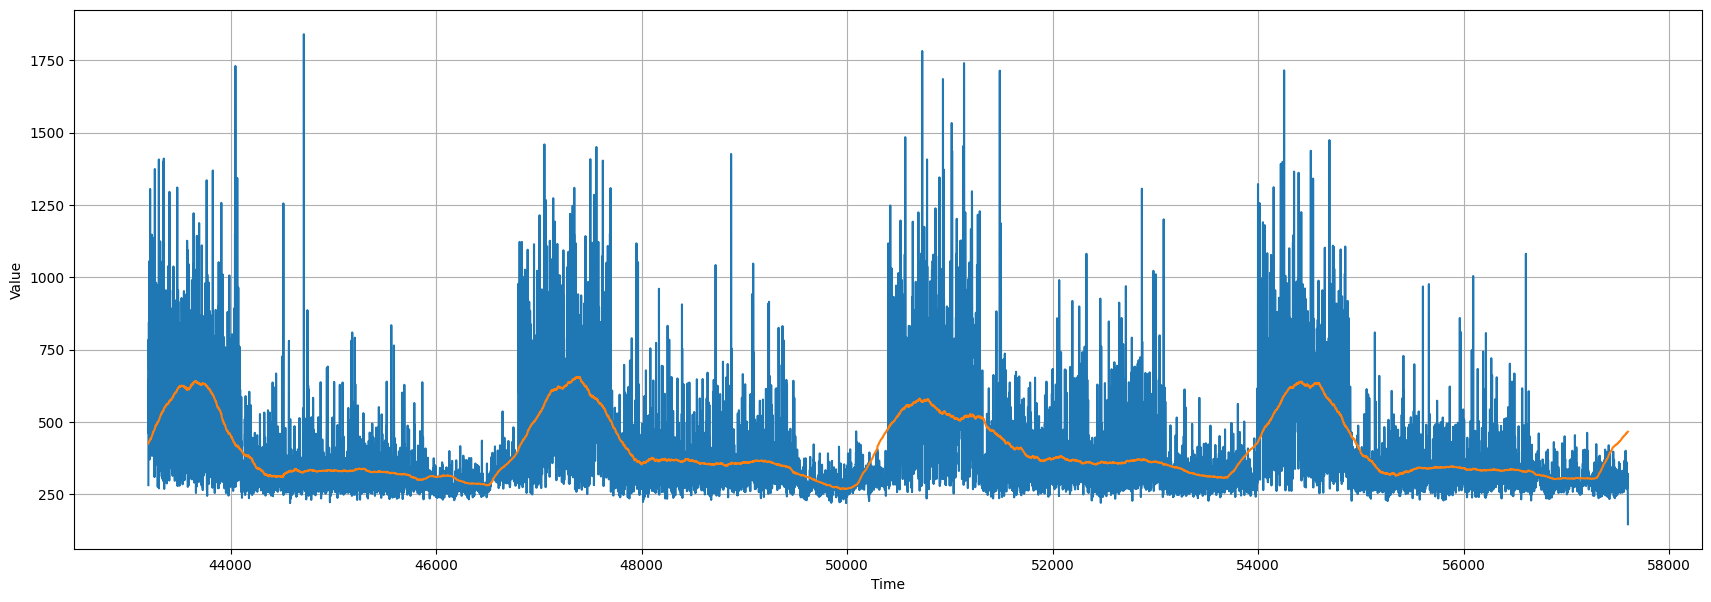

In [117]:
# Gerar a média móvel suavizada da série original
smooth_past = moving_average_forecast(latencia[split_time - 14700:-14099], 601)
# smooth_past = moving_average_forecast(latencia[split_time - 14430:-14369], 61)
# Ajustar o tamanho de diff_moving_avg para corresponder ao de smooth_past
diff_moving_avg = diff_moving_avg[-len(smooth_past):]

# Agora somar as duas séries, pois agora têm o mesmo tamanho
diff_moving_avg_plus_smooth_past = smooth_past + diff_moving_avg

# Verifique o tamanho das séries antes de plotar
print(f"Tamanho de smooth_past: {len(smooth_past)}")
print(f"Tamanho de diff_moving_avg: {len(diff_moving_avg)}")

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))


In [118]:
 # Compute the metrics
print(tf.keras.metrics.mse(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mae(x_valid, diff_moving_avg_plus_smooth_past).numpy())

20553.794808548053
91.87446809927125
